In [3]:
import numpy as np
from collections import OrderedDict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split

import math
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


In [4]:
## Code Depth 1

def construct_full_model(hparams):
    '''
    return: nn.Module. Take a sequence of input symbols and 
    return a sequence of output symbols
    '''

    # cloned
    clone = copy.deepcopy
    pff = Positiontwise_FF(d_model=hparams['d_model'], d_ff=hparams['d_ff'])
    attn = MultiHeadAttention(
        d_model=hparams['d_model'], 
        h=hparams['num_heads'], 
        attn_wt_dropout=hparams['attn_wt_dropout'],
    )
    layer_norm = LayerNorm(d_model=hparams['d_model'])

    # shared
    scaled_embed = ScaledEmbedding(hparams['vocab_size'], hparams['d_model'])
    # position_encoder = PositionEncoder(
    #     d_model=hparams['d_model'], 
    #     max_len=hparams['max_len'], 
    #     emb_var=torch.var(scaled_embed.embedding.weight)
    # )
    position_encoder = LearnedPositionEncoder(
        d_model=hparams['d_model'], 
        max_len=hparams['max_len'], 
        emb_init_var=torch.var(scaled_embed.embedding.weight).cpu().item()
    )
    embed_dropout = nn.Dropout(hparams['embed_dropout'])

    # full model
    model = EncoderDecoder(
        encoder=Encoder(
            encoder_layer=EncoderLayer(
                poswise_ff=clone(pff),
                self_attn=clone(attn), 
                layer_norm=clone(layer_norm), 
                heads_dropout=hparams['heads_dropout'],
                pff_dropout=hparams['pff_dropout']
            ), 
            N_layers=hparams['N_enc'],
            d_model=hparams['d_model'],
        ),
        decoder=Decoder(
            decoder_layer=DecoderLayer(
                poswise_ff=clone(pff),
                self_attn=clone(attn), 
                cross_attn=clone(attn), 
                layer_norm=clone(layer_norm), 
                heads_dropout=hparams['heads_dropout'],
                pff_dropout=hparams['pff_dropout']
            ),
            N_layers=hparams['N_dec'],
            d_model=hparams['d_model'],
        ),
        classifier=Classifier(
            shared_embed=scaled_embed.embedding
        ),
        inp_layer=nn.Sequential(
            OrderedDict([('scaled_embed', scaled_embed), 
                        ('position_encoder', position_encoder),
                        ('embed_dropout', embed_dropout)]
            )
        ),
        out_layer=nn.Sequential(
            OrderedDict([('scaled_embed', scaled_embed), 
                        ('position_encoder', position_encoder),
                        ('embed_dropout', embed_dropout)]
            )
        ),
        pad_idx=hparams['padding_idx']
    )

    return model

In [5]:
## Code Depth 2

class EncoderDecoder(nn.Module):

    def __init__(self, encoder, decoder, classifier, inp_layer, out_layer, pad_idx):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        self.inp_layer = inp_layer
        self.out_layer = out_layer
        self.pad_idx = pad_idx

    # def forward(self, X, Y, inp_pads, out_pads):
    def forward(self, X, Y):
        '''
        Args
        X : a sequence of input symbols. shape(batch_size=b, inp_len)
        Y : a sequence of output symbols. shape(batch_size=b, out_len)
            offset to the right by one position.
        Returns
        y_pred : predicted probabilities. shape(batch_size=b, out_len, V)
                should be offset by one position to be fed into decoder.
        '''
        # shape(batch_size=b, inp_len)
        inp_pads = (X == self.pad_idx).int()
        # shape(batch_size=b, out_len)
        out_pads = (Y == self.pad_idx).int()

        # shape(b, inp_len, d_model)
        encoder_out = self.encode(X, inp_pads)
        # shape(b, out_len, d_model)
        decoder_out = self.decode(encoder_out, Y, inp_pads, out_pads)
        # shape (b, out_len, V)
        out_logits = self.classifier(decoder_out)

        return out_logits

    def encode(self, X, inp_pads):
        # shape(b, inp_len, d_model)
        inp_embed = self.inp_layer(X)
        # shape(b, inp_len, d_model)
        encoder_out = self.encoder(inp_embed, inp_pads)
        return encoder_out

    def decode(self, encoder_out, Y, inp_pads, out_pads):
        # shape(b, out_len, d_model)
        out_embed = self.out_layer(Y)
        # shape(b, out_len, d_model)
        decoder_out = self.decoder(encoder_out, out_embed, inp_pads, out_pads)
        return decoder_out

In [6]:
## Code Depth 3
# http://karlstratos.com/notes/transformer17.pdf


class Encoder(nn.Module):

    def __init__(self, encoder_layer, N_layers, d_model):
        super(Encoder, self).__init__()
        self.encoder_layers = nn.ModuleList(
            [copy.deepcopy(encoder_layer) for _ in range(N_layers)])
        self.N_layers = N_layers
        self.d_model = d_model

    def forward(self, inp_embedding, inp_pads):
        """
        Args
        inp_embedding: Input embeddings. Already position encoded.
                        shape (batch_size=b, inp_len, d_model)
        inp_pads: Input pads. shape (batch_size=b, inp_len). 1s are padded.
        Returns
        encoder_out: output from encoder stack. 
                    shape (batch_size=b, inp_len, d_model)
        """
        m, inp_len, d_model = inp_embedding.shape

        # Make self-attn mask
        self_attn_mask = make_attn_mask(inp_pads, inp_pads, mask_forward=False)

        # Initiate encoder output tensor
        encoder_out = torch.empty(
            m, self.N_layers, inp_len, self.d_model).type_as(inp_embedding)

        # Loop through layers in stack
        last_z = inp_embedding
        for l, encoder_layer in enumerate(self.encoder_layers):
            # shape (b, inp_len, d_model)
            last_z, _ = encoder_layer(last_z, self_attn_mask)
#             print("encoder layer",l)
            encoder_out[:, l, :, :] = last_z

        return encoder_out


class Decoder(nn.Module):

    def __init__(self, decoder_layer, N_layers, d_model):
        super(Decoder, self).__init__()
        self.decoder_layers = nn.ModuleList(
            [copy.deepcopy(decoder_layer) for _ in range(N_layers)])
        self.N_layers = N_layers
        self.d_model = d_model

    def forward(self, encoder_out, out_embedding, 
                inp_pads, out_pads, max_decode=100):
        """
        Args
        encoder_out: output from encoder stack.
                    shape (batch_size=b, N_enc, inp_len, d_model)
        out_embedding: Output embedding. Shape (batch_size=b, out_len, d_model)
                    Already position encoded. Offset by one position.
        inp_pads: Input pads. shape (batch_size=b, inp_len). 1s are padded.
        out_pads: Input pads. shape (batch_size=b, out_len). 1s are padded.
        Returns
            decoder_out: output from decoder stack
        """
        # b, N_enc, inp_len, d_model = encoder_out.shape
        # b, out_len, d_model = out_embedding.shape

        self_attn_mask = make_attn_mask(out_pads, out_pads, mask_forward=True)
        cross_attn_mask = make_attn_mask(out_pads, inp_pads, mask_forward=False)

        # Loop through layers in stack
        last_o = out_embedding
        for l, decoder_layer in enumerate(self.decoder_layers):
            # shape (b, out_len, d_model)
            last_o, _, _ = decoder_layer(
                last_o, 
                # encoder_out[:, -1, :, :],
                encoder_out[:, l, :, :],
                self_attn_mask, cross_attn_mask
            )
        decoder_output = last_o
        return decoder_output


class Classifier(nn.Module):

    def __init__(self, shared_embed):
        '''
        shared_embed: same embedding matrix as the input and output layers.
                    shape(V, d_model)
        '''
        super(Classifier, self).__init__()
        self.shared_embed = shared_embed

    def forward(self, decoder_out):
        '''
        decoder_out: last layer output of decoder stack. 
                 shape(batch_size=b, out_len, d_model)
        '''
        # shape (b, out_len, d_model) mm (d_model, V) = (b, out_len, V)
        logits = decoder_out.matmul(self.shared_embed.weight.t())
        # # shape (b, out_len, V) too expensive to compute everytime
        # probs = torch.softmax(logits, dim=-1)
        return logits #, probs


class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded


class PositionEncoder(nn.Module):
    # Alternative implementation
    # https://github.com/jalammar/jalammar.github.io/blob/master/notebookes/transformer/transformer_positional_encoding_graph.ipynb

    def __init__(self, d_model, max_len):
        super(PositionEncoder, self).__init__()
        # even
        # i = 0, 2, 4, 6, ..., 510
        # j = 0, 1, 2, 3, ..., 255
        # PE(pos, i=2j) = sin(pos/10000**(2*j/d_model))
        # odd
        # i = 1, 3, 5, 7, ..., 511
        # j = 0, 1, 2, 3, ..., 255
        # PE(pos, i=2j+1) = cos(pos/10000**(2*j/d_model))
        # shape(256,)
        self.d_model = d_model
        self.max_len = max_len
        self.register_buffer(
            name="positional_encoding", 
            tensor=self.make_encodings(self.d_model, self.max_len)
        )

    @staticmethod
    def make_encodings(d_model, max_len):
        # shape (d_model/2)
        div_terms = torch.pow(
            10000, 
            2*torch.arange(start=0, # j = 0
                       end=d_model/2 # j = 255
            )/d_model
        )

        # shape (max_len,) -> shape (max_len, d_model)
        positions = torch.arange(
            max_len
            ).unsqueeze(-1).expand(-1, d_model)

        # shape (max_len, d_model)
        positional_encoding = torch.empty(
            max_len, d_model, dtype=torch.float, 
        )
    
        # shape (max_len, d_model/2)
        pos_at_even_dims = positions[:, ::2]
        # shape (max_len, d_model/2)
        pos_at_odd_dims  = positions[:, 1::2]

        # shape (max_len, d_model/2)
        div_terms_expand = div_terms.unsqueeze(0).expand(max_len, -1)

        # shape (max_len, d_model/2)
        positional_encoding[:, ::2] = torch.sin(pos_at_even_dims / div_terms_expand)
        # shape (max_len, d_model/2)
        positional_encoding[:, 1::2] = torch.cos(pos_at_odd_dims / div_terms_expand)

        # shape (max_len, d_model)
        return positional_encoding

    def forward(self, embedded):
        '''
        embedded: shape (batch_size=b, len, d_model)
        '''
        b, len, d_model = embedded.shape
        assert len <= self.max_len
        # shape (batch_size=b, len, d_model)
        positional_encoding = (
            self.positional_encoding[:len, :].unsqueeze(0).expand(b, -1, -1)
        )
        # shape (batch_size=b, len, d_model)
        return positional_encoding + embedded

    
class LearnedPositionEncoder(nn.Module):
    '''Learned, instead of sinusoidal position encoder'''
	
    def __init__(self, d_model, max_len, emb_init_var):
	    super().__init__()
	    self.pos_embedding = nn.Parameter(
            torch.nn.init.normal_(
                torch.zeros(max_len, d_model), 
			    mean=0.0, 
			    std=(emb_init_var/2)**(0.5))
	    )
		
    def forward(self, embedded):
	    '''
	    embedded: shape (batch_size=b, len, d_model)
	    '''
	    b, inp_len, d_model = embedded.shape
	    # shape (1, len, d_model)
	    pos_embeddings = self.pos_embedding[:inp_len, :].unsqueeze(0)
	    # use broadcasting
	    # shape (b, len, d_model)
	    return embedded + pos_embeddings


(1, 50, 512)


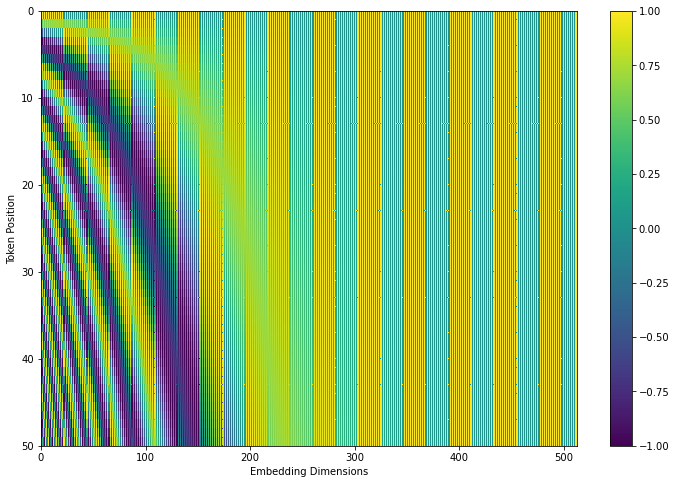

In [7]:
# Testing positional encoder

def test_positional_encoder(PositionEncoder, max_len=10, d_model=64):
    # test positional encoding
    b, len, d_model = 20, max_len, d_model
    embedding = torch.randn(b, len, d_model)
    pos_enc = PositionEncoder(d_model, 50)
    positional_encoding = pos_enc.positional_encoding
    plot_positional_encoding(positional_encoding)

def plot_positional_encoding(positional_encoding):
    '''
    positional_encoding: tensor shape (len, d_model)
    '''

    tokens, dimensions = positional_encoding.shape
  
    pos_encoding = positional_encoding.unsqueeze(0).cpu().numpy()

    print (pos_encoding.shape)

    plt.figure(figsize=(12,8))
    plt.pcolormesh(pos_encoding[0], cmap='viridis')
    plt.xlabel('Embedding Dimensions')
    plt.xlim((0, dimensions))
    plt.ylim((tokens,0))
    plt.ylabel('Token Position')
    plt.colorbar()
    plt.show()

test_positional_encoder(PositionEncoder, d_model=512)

In [8]:
## Code Depth 4
# http://karlstratos.com/notes/transformer17.pdf


class EncoderLayer(nn.Module):
    '''
    single layer encoder
    '''
    def __init__(self, poswise_ff, self_attn, layer_norm,
                heads_dropout, pff_dropout):
        super(EncoderLayer, self).__init__()
        self.poswise_ff = poswise_ff
        self.self_attn = self_attn
        self.layer_norms = nn.ModuleList([copy.deepcopy(layer_norm) for _ in range(2)])
        self.heads_dropout = nn.Dropout(heads_dropout)
        self.pff_dropout = nn.Dropout(pff_dropout)

    def forward(self, z_lm1, self_attn_mask):
        '''
        z_lm1 : last encoder layer activations. shape (batch_size=b, inp_len, d_model)
        '''

        # (b, inp_len, d_model)
        z_lm1_h, self_attn_wts = self.self_attn(z_lm1, z_lm1, self_attn_mask)
        # (b, inp_len, d_model)
        z_lm1_h_norm = self.layer_norms[0](z_lm1 + self.heads_dropout(z_lm1_h))
        # (b, inp_len, d_model)
        z_lm1_ff = self.poswise_ff(z_lm1_h_norm)
        # (b, inp_len, d_model)
        z_l = self.layer_norms[1](z_lm1_h_norm + self.pff_dropout(z_lm1_ff))
        
        if torch.isinf(z_l).any() or torch.isnan(z_l).any():
            print("z_l is nan or inf")
            import pdb; pdb.set_trace()
        
        return z_l, self_attn_wts


class DecoderLayer(nn.Module):
    '''
    single layer decoder
    '''
    def __init__(self, poswise_ff, self_attn, cross_attn, 
                layer_norm, heads_dropout, pff_dropout):
        super(DecoderLayer, self).__init__()
        self.poswise_ff = poswise_ff
        self.self_attn = self_attn
        self.cross_attn = cross_attn
        self.layer_norms = nn.ModuleList([copy.deepcopy(layer_norm) for _ in range(3)])
        self.heads_dropout = nn.Dropout(heads_dropout)
        self.pff_dropout = nn.Dropout(pff_dropout)

    def forward(self, o_lm1, encoder_l_output, self_attn_mask, cross_attn_mask):
        '''
        o_lm1 : last decoder layer activations. 
            shape (batch_size=b, out_len, d_model).
        encoder_l_output : encoder output from at the same layer index. 
                       shape (batch_size=b, inp_len, d_model)
        '''

        # (b, out_len, d_model)
        o_lm1_self_h, self_attn_wts = self.self_attn(o_lm1, o_lm1, self_attn_mask)
        # (b, out_len, d_model)
        o_lm1_self_h_norm = self.layer_norms[0](o_lm1 + self.heads_dropout(o_lm1_self_h))
        # (b, out_len, d_model)
        o_lm1_cross_h, cross_attn_wts = self.cross_attn(o_lm1_self_h_norm, encoder_l_output, cross_attn_mask)
        # (b, out_len, d_model)
        o_lm1_cross_h_norm = self.layer_norms[1](o_lm1_self_h_norm + self.heads_dropout(o_lm1_cross_h))
        # (b, out_len, d_model)
        o_lm1_ff = self.poswise_ff(o_lm1_cross_h_norm)
        # (b, out_len, d_model)
        o_l = self.layer_norms[2](o_lm1_cross_h_norm + self.pff_dropout(o_lm1_ff))
        return o_l, self_attn_wts, cross_attn_wts

In [9]:
## Code Depth 5
# https://arxiv.org/pdf/1607.06450.pdf


class LayerNorm(nn.Module):
    '''Layer Normalization'''

    def __init__(self, d_model, epsilon=1e-6):
        super(LayerNorm, self).__init__()
        self.gain = nn.Parameter(torch.ones(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon

    def forward(self, x):
        '''
        Args:
            x : shape (m, len, d_model)
        Returns:
            whitened_x : shape (m, len, d_model)
        '''
        # (m, len, 1)
        mu = torch.mean(x, dim=-1, keepdim=True)
        std = torch.std(x, dim=-1, keepdim=True)
        # (m, len, d_model)
        whitened_x = self.gain * (x - mu / (std + self.epsilon)) + self.bias
        return whitened_x


class Positiontwise_FF(nn.Module):
    '''Pointwise FeedForward / Fat-RELU'''

    def __init__(self, d_model, d_ff):
        super(Positiontwise_FF, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
  
    def forward(self, x):
        '''
        Args:
            x : shape (m, len, d_model)
        Returns:
            shape (m, len, d_model)
        '''
        return self.linear2(F.relu(self.linear1(x)))


class MultiHeadAttention(nn.Module):
    '''Multihead Attention'''

    def __init__(self, d_model, h, attn_wt_dropout):
        super(MultiHeadAttention, self).__init__()
        self.h = h
        self.d_model = d_model
        # d_k, same as d_q, d_v
        self.d_k = int(d_model / h)
        
        ############################################################
        # Break symmetry
        
        # template for WQ, WK, WV, WO projection matrices
        # shape (d_model, d_k * h = d_model)
        make_projection = lambda: nn.Linear(d_model, d_model, bias=True)
        # make WQ, WK, WV, WO
        self.projections_QKVO = nn.ModuleList([make_projection() for _ in range(4)])
        ############################################################
#         # simply use clone
    
#         # shape (d_model, d_k * h = d_model)
#         projection = nn.Linear(d_model, d_model, bias=True)
#         # clone projection to become WQ, WK, WV, WO
#         self.projections_QKVO = nn.ModuleList([copy.deepcopy(projection) for _ in range(4)]) 
        ############################################################
        # initialize WO as zeros to start training w/ identity function
        self.projections_QKVO[3].weight.data = self.projections_QKVO[3].weight.data * 0.0
        self.projections_QKVO[3].bias.data = self.projections_QKVO[3].bias.data * 0.0
        ############################################################       
        
        self.attn_wt_dropout = nn.Dropout(p=attn_wt_dropout)
        

    def forward(self, X, Y, mask):
        '''
        Args:
            X : Attender. shape (batch_size=b, attender len=n, d_model)
            Y : Attendee. shape (batch_size=b, attendee len=m, d_model)
        Return:
            attn_V : shape (b, n, h*d_k=d_model)
        '''
        b, n, d_model = X.shape

        # Project X and Y to Q, K, V matrices
        # Step 1 W(vals)
        # XQ shape(b, n, d_k *h = d_model)
        # YK shape(b, m, d_k *h = d_model)
        # YV shape(b, m, d_k *h = d_model)
        # Step 2 reshape()
        # XQ shape(b, n, h, d_k)
        # YK shape(b, m, h, d_k)
        # YV shape(b, m, h, d_k)
        # Step 3 swap axis with transpose()
        # XQ shape(b, h, n, d_k)
        # YK shape(b, h, m, d_k)
        # YV shape(b, h, m, d_k)
        XQ, YK, YV = [
                      W(vals).reshape(b, -1, self.h, self.d_k)
                      .transpose(1, 2) 
                      for (W, vals) in zip(self.projections_QKVO[:3], (X, Y, Y))]

        # attention weighted values, attention weights
        # shape (b, n, h, d_k), (b, h, n, m)
        concat_V, attn = dotproduct_attention(
            XQ, YK, YV, mask, self.attn_wt_dropout)
        # shape (b, n, h*d_k=d_model)
        concat_V = concat_V.reshape(b, n, -1)

        # project by WO, shape (b, n, h*d_k=d_model)
        attn_V = self.projections_QKVO[3](concat_V)
   
        return attn_V, attn

In [10]:
## Code Depth 6

def dotproduct_attention(Q, K, V, mask, beta_dropout, debug=False):
    '''
    Q: shape(batch_size=b, num heads=h, attender len=n, d_k)
    K: shape(batch_size=b, num heads=h, attendee len=m, d_k)
    V: shape(batch_size=b, num heads=h, attendee len=m, d_k)
    mask: shape(batch_size=b, n, m)
    beta_dropout: nn.Dropout().apply module
    '''
    b, h, n, d_k = Q.shape
    b, h, m, d_k = K.shape

    # XQ shape(b, h, n, d_k) matmul YK.T shape(b, h, d_k, m)
    # = alpha shape (b, h, n, m)
    alpha = torch.matmul(Q, K.transpose(-1, -2))/ math.sqrt(d_k)

    # Apply mask 
    # (b, h, n, m)
    mask_stack = mask.unsqueeze(1).expand(-1, h, -1, -1)
    alpha_masked = torch.masked_fill(alpha, mask_stack==1, -1e4)

    # normalize across attendee len m
    # (b, h, n, m)
    beta = beta_dropout(torch.softmax(alpha_masked, dim=-1))

    # beta shape(b, h, n, m) bmm YK.T shape(b, h, m, d_k) = shape (b, h, n, d_k)
    # transpose to (b, n, h, d_k)
    wt_V = torch.matmul(beta, V).transpose(1, 2)

    if debug:
        print('alpha\n', alpha)
        print('mask_stack\n', mask_stack)
        print('alpha_masked\n', alpha_masked)
        print('beta\n', beta)
        print('wt_V\n', wt_V)
        
    return wt_V, beta


def ref_attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 1, -1e9)
    p_attn = torch.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


def test_attention(attn_fn):
    torch.manual_seed(123)
    b, h, n, m, d_k = 1, 2, 3, 3, 5
    Q = torch.randn(b, h, n, d_k)
    K = torch.randn(b, h, m, d_k)
    V = torch.randn(b, h, m, d_k)

    # print('Q\n', Q)
    # print('K\n', K)
    # print('V\n', V)

    mask = torch.zeros((b, n, m))
    mask[:,:,1] = 1
    mask[:,2,:1] = 1
    print('input', mask)

    my_wt_V = dotproduct_attention(Q, K, V, mask, nn.Dropout(0.0), debug=True)
    ref_wt_V, ref_p_attn = ref_attention(Q, K, V, mask, nn.Dropout(0.0))
  
    print('ref wt_V\n', ref_wt_V.transpose(1, 2))
    print('ref wt_V\n', ref_wt_V.shape)

test_attention(dotproduct_attention)

input tensor([[[0., 1., 0.],
         [0., 1., 0.],
         [1., 1., 0.]]])
alpha
 tensor([[[[-1.0231,  0.0260,  0.2767],
          [ 0.7859,  0.2193,  0.9244],
          [-0.5686,  1.7561,  1.9875]],

         [[-0.5513, -0.7215,  0.3740],
          [ 0.9782,  1.1411, -0.4604],
          [-0.0315,  0.7704, -0.9848]]]])
mask_stack
 tensor([[[[0., 1., 0.],
          [0., 1., 0.],
          [1., 1., 0.]],

         [[0., 1., 0.],
          [0., 1., 0.],
          [1., 1., 0.]]]])
alpha_masked
 tensor([[[[-1.0231e+00, -1.0000e+04,  2.7667e-01],
          [ 7.8594e-01, -1.0000e+04,  9.2435e-01],
          [-1.0000e+04, -1.0000e+04,  1.9875e+00]],

         [[-5.5126e-01, -1.0000e+04,  3.7404e-01],
          [ 9.7823e-01, -1.0000e+04, -4.6042e-01],
          [-1.0000e+04, -1.0000e+04, -9.8484e-01]]]])
beta
 tensor([[[[0.2142, 0.0000, 0.7858],
          [0.4655, 0.0000, 0.5345],
          [0.0000, 0.0000, 1.0000]],

         [[0.2839, 0.0000, 0.7161],
          [0.8082, 0.0000, 0.1918],
   

In [11]:
def make_attn_mask(attender_pads, attendee_pads, mask_forward=False, debug=False):
    '''
    Mask away attendee positions from attender.
    Args:
        attender_pads: shape(batch_size=b, attender len=n). 1s are pads.
        attendee_pads: shape(batch_size=b, attender len=m). 1s are pads.
    Return:
        attn_mask: shape(b, n, m)
    '''

    b, n = attender_pads.shape
    b, m = attendee_pads.shape

    if mask_forward: 
        assert n == m
        # shape (n, m)
        try:
            future_mask = torch.from_numpy(
                np.triu(np.ones((n, m)), k=1)).type_as(attender_pads)
        except:
            import pdb; pdb.set_trace()
        # shape (b, n, m)
        future_mask_expanded = future_mask.unsqueeze(0).expand(b, -1, -1)

    # shape(b, n, m)
    attender_mask_expanded = attender_pads.unsqueeze(-1).expand(-1, -1, m)
    # shape(b, n, m)
    attendee_mask_expanded = attendee_pads.unsqueeze(1).expand(-1, n, -1)

    # shape(b, n, m)
    if mask_forward: 
        sum_mask = attender_mask_expanded + attendee_mask_expanded + future_mask
    else:
        sum_mask = attender_mask_expanded + attendee_mask_expanded
    sum_mask = (sum_mask > 0).type(torch.int)

    if debug:
        if mask_forward:
            print('future_mask\n',future_mask)
        print('attender_mask_expanded\n',attender_mask_expanded)
        print('attendee_mask_expanded\n',attendee_mask_expanded)
        print('sum mask\n', sum_mask)

    return sum_mask


def test_make_attn_mask():
    #   attender_pads = torch.tensor([[0,0,0,1,1], [0,0,1,1,1], [0,0,0,0,0]])
    attender_pads = torch.tensor([[0,0,0,1], [0,0,0,0], [0,0,0,1]])
    attendee_pads = torch.tensor([[0,0,0,1], [0,0,0,0], [0,0,0,1]])
    print('Cross Attention:')
    make_attn_mask(attender_pads, attendee_pads, mask_forward=False, debug=True)
    print('--------------------------------------')
    print('Self Attention:')
    make_attn_mask(attender_pads, attender_pads, mask_forward=True, debug=True)


test_make_attn_mask()

Cross Attention:
attender_mask_expanded
 tensor([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1, 1, 1, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1, 1, 1, 1]]])
attendee_mask_expanded
 tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]]])
sum mask
 tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]]], dtype=torch.int32)
--------------------------------------
Self Attention:
futur

In [12]:
class LabelSmoothedLoss(nn.Module):
    '''
    KL divergence Loss with Label Smoothing and Temperature scaling
    '''

    def __init__(self, K, padding_idx, smoothing_const=0.0, temperature_const=1.0):
        super(LabelSmoothedLoss, self).__init__()
        self.smoothing_const = smoothing_const
        self.temperature_const = temperature_const
        self.K = K
        self.padding_idx = padding_idx
        self.KLdiv_criterion = nn.KLDivLoss(reduction='sum')
        self.logprob = nn.LogSoftmax(dim=-1)


    def forward(self, logits, labels, debug=False):
        '''
        logits: shape (batch_size=b, output_len=m, vocab_size=K)
        labels: shape (batch_size=b, output_len=m)
        '''
        b, m, K = logits.shape

        # Temperature Scaling
        # shape (b*m, K)
        scaled_logits = (logits / self.temperature_const).reshape(-1, K)
        pred_logprobs = self.logprob(scaled_logits)

        # Expand Labels to one-hot, Smooth the values
        gt_probs_smoothed = torch.full(
            size=(b*m, K), 
            # fill_value=self.smoothing_const / (K - 1), # more mathematicaly correct
            fill_value=self.smoothing_const / (K - 2) #minus true and padding
        ).type_as(logits)

        gt_probs_smoothed = gt_probs_smoothed.scatter(
            dim=-1, 
            index=labels.reshape(-1, 1), 
            value=(1. - self.smoothing_const),
            # value=(1. - self.smoothing_const) + (self.smoothing_const / (K - 1)) # more mathematicaly correct
        )
        # Zero out padding idx
        # shape (b*m, K)
        gt_probs_smoothed[:, self.padding_idx] = 0.
    
        # Apply mask (e.g. if end of context is padded)
        # shape (b*m, 1)
        mask_ctx_pos = torch.nonzero(torch.flatten(labels) == self.padding_idx)
        if mask_ctx_pos.dim() > 0:
            # zero out rows for padded context positions
            # e.g. word at position 10 is a pad, we zero out all probs for row 10
            gt_probs_smoothed.index_fill_(
                dim=0, index=mask_ctx_pos.squeeze(), value=0.0)

        if debug:
            print(scaled_logits)
            print(labels_onehot)
            print(mask_ctx_pos)

        assert torch.all(torch.eq(torch.sum(gt_probs_smoothed, dim=-1), 1.))

        return self.KLdiv_criterion(input=pred_logprobs, target=gt_probs_smoothed)


# Only Use for verification
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


def test_loss_function(myLoss, refLoss, smoothing_const, temperature_const):
    K = 3
    padding_idx = 0

    torch.manual_seed(123)
    myKL = myLoss(K, padding_idx, smoothing_const, temperature_const)
    refKL = refLoss(K, padding_idx, smoothing_const)

    labels = torch.tensor([[1, 1, 1, 2], [2, 2, 1, 1], [1, 1, 2, 1], [2, 1, 1, 1], [2, 1, 1, 2]])
    inputs = torch.randn(5, 4, 3) * 4

    ref_loss = refKL(F.log_softmax(inputs, dim=-1).reshape(-1, 3), torch.flatten(labels))
    my_loss = myKL(inputs, labels )
    #   if temperature_const == 1.0:
    #     assert ref_loss == my_loss
    print(ref_loss, )
    print(my_loss)

test_loss_function(myLoss=LabelSmoothedLoss, refLoss=LabelSmoothing, smoothing_const=0.1, temperature_const=1.0)

tensor(75.7293)
tensor(75.7293)


/anaconda/envs/playground/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


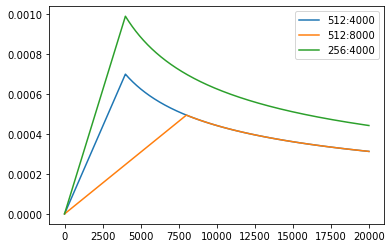

In [13]:
class LRScheduledAdam(Optimizer):
    """
    Implements Adam algorithm with learning rate schedule.
    Modified based on hugging face implementation:
    https://huggingface.co/transformers/_modules/transformers/optimization.html#AdamW

    Parameters:
        params (:obj:`Iterable[torch.nn.parameter.Parameter]`):
            Iterable of parameters to optimize or dictionaries defining parameter groups.
        d_model (:obj:`int`):
            Dimension of embedding vector.
        warmup_steps (:obj:`int`):
            Steps for warmup before learning rate peaks.
        lr (:obj:`float`, `optional`, defaults to 0.):
            The learning rate to use.
        betas (:obj:`Tuple[float,float]`, `optional`, defaults to (0.9, 0.999)):
            Adam's betas parameters (b1, b2).
        eps (:obj:`float`, `optional`, defaults to 1e-6):
            Adam's epsilon for numerical stability.
        weight_decay (:obj:`float`, `optional`, defaults to 0):
            Decoupled weight decay to apply.
        correct_bias (:obj:`bool`, `optional`, defaults to `True`):
            Whether ot not to correct bias in Adam (for instance, in Bert TF repository they use :obj:`False`).
    """

    def __init__(
        self,
        params: Iterable[torch.nn.parameter.Parameter],
        d_model: int,
        warmup_steps: int,
        lr: float = 0.,
        betas: Tuple[float, float] = (0.9, 0.98),
        eps: float = 1e-9,
        correct_bias: bool = True,
    ):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[1]))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(eps))
        defaults = dict(
            lr=lr, betas=betas, eps=eps, correct_bias=correct_bias)
        super().__init__(params, defaults)
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def calc_step_size(self, step_num):
        '''udpate lr'''
        return (
            self.d_model**(-0.5) * min(step_num**(-0.5), step_num * self.warmup_steps**(-1.5))
        )

    def step(self, closure: Callable = None):
        """
        Performs a single optimization step.

        Arguments:
            closure (:obj:`Callable`, `optional`): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                exp_avg.mul_(beta1).add_(grad, alpha=1.0 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
                denom = exp_avg_sq.sqrt().add_(group["eps"])

                group["lr"] = self.calc_step_size(state["step"])
                step_size = group["lr"]
                if group["correct_bias"]:  # No bias correction for Bert
                    bias_correction1 = 1.0 - beta1 ** state["step"]
                    bias_correction2 = 1.0 - beta2 ** state["step"]
                    step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(exp_avg, denom, value=-step_size)
        return loss

def plot_lr(myOpt):
    model = nn.Linear(2,3)
    opts = [myOpt(model.parameters(), 512, 4000), 
            myOpt(model.parameters(), 512, 8000),
            myOpt(model.parameters(), 256, 4000)]
    plt.plot(np.arange(1, 20000), [[opt.calc_step_size(i) for opt in opts] for i in range(1, 20000)])
    plt.legend(["512:4000", "512:8000", "256:4000"])

plot_lr(LRScheduledAdam)

In [14]:
def greedy_decode_sequence(model, X, start_idx, pad_idx, max_len):
    '''
    Greedy Decoding
    X : a sequence of input symbols. shape(batch_size=b, inp_len)
    start_idx: int.
    pad_idx: int.
    max_len: int. Maximum context length for generation. Include <SOS> and <EOS>
    '''

    b, inp_len = X.shape
    inp_pads = (X == pad_idx).int()

    # encode inputs
    # shape (b, inp_len, d_model)
    encoded_memory = model.encode(X, inp_pads)
 
    # shape (b, max_len) e.g. (b, 10)
    Y = torch.ones(b, max_len).type_as(X) * pad_idx
    Y[:,0] = start_idx
    # shape (b, max_len)
    out_pads = (Y == pad_idx).int()
  
    # generate one token at a time
    for t in range(1, max_len): # (1 to 9)

        # shape (b, t, d_model)
        decoder_output = model.decode(encoded_memory, Y[:, :t], inp_pads, out_pads[:, :t])

        # shape (b, t, V)
        decoded_logits = model.classifier(decoder_output)
        # decoded_probs = torch.softmax(decoded_logits, dim=-1)
    
        # shape (b,), (b,)
        max_prob, max_idx = torch.max(decoded_logits[:, -1, :], dim=-1)
    
        # update Y, out_pads for next timestep
        Y[:, t] = max_idx
        out_pads[:, t] = (max_idx == pad_idx).int()

    # shape (b, max_len)
    # (1 to 9)
    return Y[:, 1:]

In [15]:
def multiclass_accuracy(start_idx, pad_idx, pred, labels):
    '''
    pred: shape (batch_size, max_len)
    labels: shape (batch_size, max_len) 
    '''
    assert not start_idx in labels, '<GO> should not be evaluated'

    mask = 1 - (labels == pad_idx).int() # 0 means padded
    tot_not_masked = torch.sum(mask)

    same = (pred == labels).int() * mask
    tot_correct = torch.sum(same)

    return tot_correct * 1.0 / tot_not_masked

In [16]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

class Transformer(pl.LightningModule):
    
    def __init__(self, hparams):
        super(Transformer, self).__init__()
        self.hparams = hparams
        
        self.encdec_model = construct_full_model(hparams)
        
        self.loss_criterion = LabelSmoothedLoss(
            K=hparams['vocab_size'],
            padding_idx=hparams['padding_idx'],
            smoothing_const=hparams['smoothing_const'],
            temperature_const=hparams['temperature_const']
        )

        self.accuracy = partial(
            multiclass_accuracy, hparams['start_idx'], hparams['padding_idx'])
    
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)

    def generate_sequence(self, X, start_idx, pad_idx, max_len):
        # shape (b, max_len)
        Y = greedy_decode_sequence(self.encdec_model, X, start_idx, pad_idx, max_len)
        return Y

    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    def forward(self, X, Y, student_force_acc=False):
        '''
        X : (b, inp_len)
        Y : (b, out_len)
        '''

        # fwd
        # inp X[:,:]: tensor([1, 9, 6, 7, 9, 2])
        # out Y[:, :-1]: tensor([1, 9, 6, 7, 9])
        logits = self.encdec_model(X[:,:], Y[:, :-1])
        
        # loss
        # target Y[:, 1:]: tensor([9, 6, 7, 9, 2])
        loss = self.loss_criterion(logits, Y[:, 1:])

        # acc
        if student_force_acc:
            y_hat = self.generate_sequence(
                X, 
                hparams['start_idx'], 
                hparams['padding_idx'], 
                hparams['max_len'])         
        else:
            _, y_hat = torch.max(logits, dim=-1)

        try:
            acc = self.accuracy(y_hat, Y[:, 1:])
        except:
            import pdb; pdb.set_trace()

        return loss, acc, y_hat

    def training_step(self, batch, batch_nb):
        # (b, inp_len), (b, 1 GO + out_len) 
        X, Y = batch     
        loss, acc, y_hat = self(X, Y)
        # logs
        step_metrics = {'train_loss': loss, 'train_acc':acc}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        # check if tensors are init at 16-bit here
        #import pdb; pdb.set_trace()
        
        X, Y = batch
        loss, acc, y_hat = self(X, Y, student_force_acc=True)
        
        # print sample
        print('X:',X[0], '\nY:',Y[0] ,'\ninp X', X[0, :], '\nout Y[:, :-1]', Y[0, :-1], 
              '\ntgt Y', Y[0, 1:],'\ny_hat', y_hat[0])
        
        # log
        step_metrics = {'val_loss': loss, 'val_acc': acc}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        X, Y = batch
        loss, acc, y_hat = self(X, Y, student_force_acc=True)
        # log
        step_metrics = {'test_loss': loss, 'test_acc': acc}
        # print('X:',X[0], '\nY:',Y[0], '\ny_hat', y_hat[0])
        self.log_metrics(step_metrics)
        return step_metrics
        
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        # log metrics
        epoch_metrics = {
            'avg_val_loss': avg_loss, 
            'avg_val_acc': avg_acc,
            'encoder_pff_wt': self.encdec_model.encoder.encoder_layers[0].poswise_ff.linear1.weight[0,0],
            'decoder_pff_wt': self.encdec_model.decoder.decoder_layers[0].poswise_ff.linear1.weight[0,0]}
        self.log_metrics(epoch_metrics)
        return epoch_metrics

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        # log
        epoch_metrics = {'avg_test_loss': avg_loss, 'avg_test_acc': avg_acc}
        self.log_metrics(epoch_metrics)
        return epoch_metrics
        
    def configure_optimizers(self):
        opt = LRScheduledAdam(
            params=self.encdec_model.parameters(),
            d_model=self.hparams['d_model'], 
            warmup_steps=self.hparams['warmup_steps'],
            lr=0.,
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            correct_bias=True
        )
        # opt = torch.optim.SGD(self.encdec_model.parameters(), lr=0.001, momentum=0.9)
        # opt = AdamW(
        #     params=self.encdec_model.parameters(),
        #     lr=0.,
        #     betas=(
        #         self.hparams['adam_beta1'], self.hparams['adam_beta2']),
        #     eps=self.hparams['adam_epsilon'],
        # )
        return opt

In [17]:
# Generate dataloaders

class ToyDataset(Dataset):
    '''Toy Dataset. Input copying task.'''

    def __init__(self, V=20, seed=0, context_len=6, tot_size=1000):
        super(ToyDataset, self).__init__()
        np.random.seed(seed)
        
        
#         #############################################################
#         # completely random series
#         self.X = np.random.randint(3, V, size=(tot_size, context_len)) # [3, 49]
#         self.X[:, 0] = 1 # <SOS>
#         self.X[:, -1] = 2 # <EOS>
#         self.Y = self.X[:,:].copy()
        #############################################################
        # reverse order
        self.X = np.random.randint(3, V, size=(tot_size, context_len)) # [3, 49]
        self.X[:, 0] = 1 # <SOS>
        self.X[:, -1] = 2 # <EOS>
        self.Y = self.X[:,::-1].copy()        
        self.Y[:, 0] = 1 # <SOS>
        self.Y[:, -1] = 2 # <EOS>  
        #############################################################
#         # + 1 series
#         self.X = np.empty((tot_size, context_len))
#         self.X[:, 1] = np.random.randint(3, V - (context_len - 3), size=(tot_size, ))
#         for i in range(2, context_len):
#             self.X[:, i] = self.X[:, i-1] + 1
#         self.X[:, 0] = 1 # <SOS>
#         self.X[:, -1] = 2 # <EOS>
#         self.Y = self.X[:,:].copy()   
#         #############################################################
#         # sum of current X + last X
#         self.X = np.empty((tot_size, context_len))
#         self.X[:, 1:context_len] = np.random.randint(3, V//2+1, size=(tot_size,context_len-1))        
#         self.X[:, 0] = 1 # <SOS>
#         self.X[:, -1] = 2 # <EOS>
#         self.Y = np.empty((tot_size, context_len))
#         for i in range(1, context_len):
#             self.Y[:, i] = self.X[:, i-1] + self.X[:, i]
#         self.Y[:, 0] = 1 # <SOS>
#         self.Y[:, -1] = 2 # <EOS>          
#         #############################################################
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx, :]).long()
        y = torch.from_numpy(self.Y[idx, :]).long()
        return x, y

toy_dataset = ToyDataset()

# Samples of datasets

## replicate random
```
X
(tensor([[ 1, 18,  3,  6,  6,  2],
         [ 1,  7,  9, 15,  4,  2],
         [ 1, 17,  8, 16, 11,  2],
         [ 1,  8, 18, 18,  3,  2],
         [ 1, 10,  3,  4, 12,  2],
         [ 1,  6, 14,  5,  3,  2],
         [ 1,  8,  9, 11, 18,  2],
         [ 1, 13,  4,  4, 10,  2],
         [ 1,  9, 14, 17,  3,  2],
         [ 1, 15, 13, 14,  7,  2]]),
Y
 tensor([[ 1, 18,  3,  6,  6,  2],
         [ 1,  7,  9, 15,  4,  2],
         [ 1, 17,  8, 16, 11,  2],
         [ 1,  8, 18, 18,  3,  2],
         [ 1, 10,  3,  4, 12,  2],
         [ 1,  6, 14,  5,  3,  2],
         [ 1,  8,  9, 11, 18,  2],
         [ 1, 13,  4,  4, 10,  2],
         [ 1,  9, 14, 17,  3,  2],
         [ 1, 15, 13, 14,  7,  2]]))
```


## reversed random
```
(tensor([[ 1, 18,  3,  6,  6,  2],
         [ 1,  7,  9, 15,  4,  2],
         [ 1, 17,  8, 16, 11,  2],
         [ 1,  8, 18, 18,  3,  2],
         [ 1, 10,  3,  4, 12,  2],
         [ 1,  6, 14,  5,  3,  2],
         [ 1,  8,  9, 11, 18,  2],
         [ 1, 13,  4,  4, 10,  2],
         [ 1,  9, 14, 17,  3,  2],
         [ 1, 15, 13, 14,  7,  2]]),
 tensor([[ 1,  6,  6,  3, 18,  2],
         [ 1,  4, 15,  9,  7,  2],
         [ 1, 11, 16,  8, 17,  2],
         [ 1,  3, 18, 18,  8,  2],
         [ 1, 12,  4,  3, 10,  2],
         [ 1,  3,  5, 14,  6,  2],
         [ 1, 18, 11,  9,  8,  2],
         [ 1, 10,  4,  4, 13,  2],
         [ 1,  3, 17, 14,  9,  2],
         [ 1,  7, 14, 13, 15,  2]]))
```


## autoregressive +1 series
```
X
(tensor([[ 1, 15, 16, 17, 18,  2],
         [ 1,  8,  9, 10, 11,  2],
         [ 1,  3,  4,  5,  6,  2],
         [ 1,  6,  7,  8,  9,  2],
         [ 1, 14, 15, 16, 17,  2],
         [ 1,  6,  7,  8,  9,  2],
         [ 1, 10, 11, 12, 13,  2],
         [ 1, 12, 13, 14, 15,  2],
         [ 1,  6,  7,  8,  9,  2],
         [ 1,  8,  9, 10, 11,  2]]),
Y
 tensor([[ 1, 15, 16, 17, 18,  2],
         [ 1,  8,  9, 10, 11,  2],
         [ 1,  3,  4,  5,  6,  2],
         [ 1,  6,  7,  8,  9,  2],
         [ 1, 14, 15, 16, 17,  2],
         [ 1,  6,  7,  8,  9,  2],
         [ 1, 10, 11, 12, 13,  2],
         [ 1, 12, 13, 14, 15,  2],
         [ 1,  6,  7,  8,  9,  2],
         [ 1,  8,  9, 10, 11,  2]]))
```


## current of X + last of X series
```
X
(tensor([[ 1,  7, 10,  8,  3,  2],
         [ 1,  6,  6, 10,  4,  2],
         [ 1,  8,  5,  7, 10,  2],
         [ 1,  3,  3,  7,  5,  2],
         [ 1,  9, 10, 10,  9,  2],
         [ 1,  4,  8,  4,  8,  2],
         [ 1,  4,  7,  6,  3,  2],
         [ 1,  8,  9, 10, 10,  2],
         [ 1,  5,  6,  3,  4,  2],
         [ 1,  8,  6,  6,  9,  2]]),
Y
 tensor([[ 1,  8, 17, 18, 11,  2],
         [ 1,  7, 12, 16, 14,  2],
         [ 1,  9, 13, 12, 17,  2],
         [ 1,  4,  6, 10, 12,  2],
         [ 1, 10, 19, 20, 19,  2],
         [ 1,  5, 12, 12, 12,  2],
         [ 1,  5, 11, 13,  9,  2],
         [ 1,  9, 17, 19, 20,  2],
         [ 1,  6, 11,  9,  7,  2],
         [ 1,  9, 14, 12, 15,  2]]))
```

In [18]:
class ToyDataModule(pl.LightningDataModule):
    # https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw

    def __init__(self, batch_size, V, seed, context_len, tot_size):
        super().__init__()
        self.batch_size=batch_size
        self.V = V
        self.seed = seed
        self.context_len = context_len
        self.tot_size = tot_size

    def setup(self, stage=None):
        if stage == 'fit' or stage in None:
            self.toy_train = ToyDataset(
                V=self.V, seed=self.seed, 
                context_len=self.context_len, tot_size=self.tot_size)
            self.toy_val = self.toy_train            
            # self.toy_val = ToyDataset(
            #     V=self.V, seed=42, 
            #     context_len=self.context_len, tot_size=self.batch_size*2) 
        if stage == 'test' or stage is None:
            self.toy_test = self.toy_train
            # self.toy_test = ToyDataset(
            #     V=self.V, seed=41, 
            #     context_len=self.context_len, tot_size=self.batch_size*2)
            
    def train_dataloader(self):
        train_loader = DataLoader(self.toy_train, batch_size=self.batch_size, shuffle=False)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.toy_val, batch_size=self.batch_size, shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(self.toy_test, batch_size=self.batch_size, shuffle=False)
        return test_loader

In [19]:
class MultiHeadAttention(nn.Module):
    '''Multihead Attention'''

    def __init__(self, d_model, h, attn_wt_dropout):
        super(MultiHeadAttention, self).__init__()
        self.h = h
        self.d_model = d_model
        # d_k, same as d_q, d_v
        self.d_k = int(d_model / h)
        
        ############################################################
#         # Break symmetry
        
#         # template for WQ, WK, WV, WO projection matrices
#         # shape (d_model, d_k * h = d_model)
#         make_projection = lambda: nn.Linear(d_model, d_model, bias=True)
#         # make WQ, WK, WV, WO
#         self.projections_QKVO = nn.ModuleList([make_projection() for _ in range(4)])
        ############################################################
        # simply use clone
    
        # shape (d_model, d_k * h = d_model)
        projection = nn.Linear(d_model, d_model, bias=True)
        # clone projection to become WQ, WK, WV, WO
        self.projections_QKVO = nn.ModuleList([copy.deepcopy(projection) for _ in range(4)]) 
        ############################################################
        # initialize WO as zeros to start training w/ identity function
        self.projections_QKVO[3].weight.data = self.projections_QKVO[3].weight.data * 0.0
        self.projections_QKVO[3].bias.data = self.projections_QKVO[3].bias.data * 0.0
        ############################################################       
        
        self.attn_wt_dropout = nn.Dropout(p=attn_wt_dropout)
        

    def forward(self, X, Y, mask):
        '''
        Args:
            X : Attender. shape (batch_size=b, attender len=n, d_model)
            Y : Attendee. shape (batch_size=b, attendee len=m, d_model)
        Return:
            attn_V : shape (b, n, h*d_k=d_model)
        '''
        b, n, d_model = X.shape

        # Project X and Y to Q, K, V matrices
        # Step 1 W(vals)
        # XQ shape(b, n, d_k *h = d_model)
        # YK shape(b, m, d_k *h = d_model)
        # YV shape(b, m, d_k *h = d_model)
        # Step 2 reshape()
        # XQ shape(b, n, h, d_k)
        # YK shape(b, m, h, d_k)
        # YV shape(b, m, h, d_k)
        # Step 3 swap axis with transpose()
        # XQ shape(b, h, n, d_k)
        # YK shape(b, h, m, d_k)
        # YV shape(b, h, m, d_k)
        XQ, YK, YV = [
                      W(vals).reshape(b, -1, self.h, self.d_k)
                      .transpose(1, 2) 
                      for (W, vals) in zip(self.projections_QKVO[:3], (X, Y, Y))]

        # attention weighted values, attention weights
        # shape (b, n, h, d_k), (b, h, n, m)
        concat_V, attn = dotproduct_attention(
            XQ, YK, YV, mask, self.attn_wt_dropout)
        # shape (b, n, h*d_k=d_model)
        concat_V = concat_V.reshape(b, n, -1)

        # project by WO, shape (b, n, h*d_k=d_model)
        attn_V = self.projections_QKVO[3](concat_V)
   
        return attn_V, attn

In [ ]:
## W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


hparams = {
    'd_model': 512,
    'd_ff': 2048,
    'max_len': 6,
    'num_heads': 2,
    'embed_dropout': 0.0,
    'attn_wt_dropout': 0.0,
    'heads_dropout': 0.0,
    'pff_dropout': 0.0,
    'N_enc': 2,
    'N_dec': 2,
    'start_idx': 1,
    'padding_idx': 0,
    'smoothing_const': 0.1,
    'temperature_const': 1.0,
    'adam_beta1': 0.9,
    'adam_beta2': 0.98,
    'adam_epsilon': 1e-9,
    'warmup_steps': 12000,
    'vocab_size': 20
}

# model
my_transformer = Transformer(hparams)
print(pl.core.memory.ModelSummary(my_transformer, mode='full'),'\n')
# data
toy_data = ToyDataModule(batch_size=100, V=hparams['vocab_size'], seed=40, context_len=hparams['max_len'], tot_size=500)
# logger
wd_logger = WandbLogger(name="test-reverse-32bit-warmup12000-embedinit",project='pytorchlightning_test')
# wd_logger = WandbLogger(name="test-dummy",project='pytorchlightning_test')
# trainer
trainer = pl.Trainer(
    gpus=1, min_epochs=2, max_epochs=50000, 
    logger=wd_logger,log_gpu_memory='all',
    precision=32, amp_backend='apex', amp_level='O3' )
# fit!
with torch.autograd.detect_anomaly():
    trainer.fit(my_transformer, toy_data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


   | Name                                                                | Type                   | Params
----------------------------------------------------------------------------------------------------------------
0  | encdec_model                                                        | EncoderDecoder         | 14 M  
1  | encdec_model.encoder                                                | Encoder                | 6 M   
2  | encdec_model.encoder.encoder_layers                                 | ModuleList             | 6 M   
3  | encdec_model.encoder.encoder_layers.0                               | EncoderLayer           | 3 M   
4  | encdec_model.encoder.encoder_layers.0.poswise_ff                    | Positiontwise_FF       | 2 M   
5  | encdec_model.encoder.encoder_layers.0.poswise_ff.linear1            | Linear                 | 1 M   
6  | encdec_model.encoder.encoder_layers.0.poswise_ff.linear2            | Linear                 | 1 M   
7  | encdec_model.encoder.encod

/anaconda/envs/playground/lib/python3.7/site-packages/torch/autograd/anomaly_mode.py:70: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  warnings.warn('Anomaly Detection has been enabled. '
wandb: wandb version 0.10.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name           | Type              | Params
-----------------------------------------------------
0 | encdec_model   | EncoderDecoder    | 14 M  
1 | loss_criterion | LabelSmoothedLoss | 0     
/anaconda/envs/playground/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')


/anaconda/envs/playground/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/anaconda/envs/playground/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,

X: tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
Y: tensor([ 1, 15,  4,  8, 10,  2], device='cuda:0') 
inp X tensor([ 1, 10,  8,  4, 15,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 15,  4,  8, 10], device='cuda:0') 
tgt Y tensor([15,  4,  8, 10,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
Y: tensor([ 1,  8, 16,  5,  4,  2], device='cuda:0') 
inp X tensor([ 1,  4,  5, 16,  8,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1,  8, 16,  5,  4], device='cuda:0') 
tgt Y tensor([ 8, 16,  5,  4,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
Y: tensor([ 1, 19,  8,  6, 16,  2], device='cuda:0') 
inp X tensor([ 1, 16,  6,  8, 19,  2], device='cuda:0') 
out Y[:, :-1] tensor([ 1, 19,  8,  6, 16], device='cuda:0') 
tgt Y tensor([19,  8,  6, 16,  2], device='cuda:0') 
y_hat tensor([1, 1, 1, 1, 1], device='cuda:0')
X: tensor([ 1,  6, 16,